In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import xml.etree.ElementTree as etree
import os
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from new_preprocessing import parse_annotation, BatchGenerator
from utils import normalize
%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 8
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [3]:
train_image_folder = '../VOCdevkit/images/'
train_annot_folder = '../VOCdevkit/annots/'

In [4]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [5]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder)

In [8]:
with open('all_train_img.pkl', 'wb') as pickfile:
    pickle.dump(train_imgs, pickfile)

In [5]:
with open('all_train_img.pkl', 'rb') as infile:
    train_imgs = pickle.load(infile)

In [6]:
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

In [7]:
count = 0
for x_train, y_train in train_batch:
    print(x_train[0].shape, y_train.shape)
    count +=1
    if count == 2:
        break

(8, 416, 416, 3) (8, 13, 13, 5, 5)
(8, 416, 416, 3) (8, 13, 13, 5, 5)


In [9]:
y_train[0, :, :, :, 4]

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0

### testing the method with vanilla vgg16

In [8]:
from keras.models import load_model, model_from_json
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [9]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)     0         
__________

In [11]:
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
x = model.output

output = Conv2D(BOX * (4 + 1), (1,1), strides=(1,1), padding='same', name='conv_23', kernel_initializer='lecun_normal')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1), name='reshape')(output)
output = Lambda(lambda args: args[0])([output, true_boxes])
model = Model([model.input, true_boxes], output)
        
layer = model.layers[-4]
weights = layer.get_weights()
new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)
layer.set_weights([new_kernel, new_bias])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 416, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 416, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 208, 208, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [12]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    #class_mask = tf.zeros(mask_shape)
    
    #seen = tf.Variable(0.)
    #total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    #pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    #true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    #class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    #no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    #seen = tf.assign_add(seen, 1.)
    
    #true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
    #                      lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
    #                               true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
    #                               tf.ones_like(coord_mask)],
    #                      lambda: [true_box_xy, 
    #                               true_box_wh,
    #                               coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    #nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    #loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    #loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    #total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    #loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    #loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [13]:

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

In [14]:
model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 2, 
                    verbose          = 1,
                    #validation_data  = valid_batch,
                    #validation_steps = len(valid_batch),
                    #callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/2
3386/3386 [==============================] - 2162s 639ms/step - loss: 2.2690
Epoch 2/2
3386/3386 [==============================] - 2158s 637ms/step - loss: 1.9253


In [15]:
model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 10, 
                    verbose          = 1,
                    #validation_data  = valid_batch,
                    #validation_steps = len(valid_batch),
                    #callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/10
3386/3386 [==============================] - 2154s 636ms/step - loss: 1.8022
Epoch 2/10
3386/3386 [==============================] - 2143s 633ms/step - loss: 1.7188
Epoch 3/10
3386/3386 [==============================] - 2130s 629ms/step - loss: 1.6477
Epoch 4/10
3386/3386 [==============================] - 2130s 629ms/step - loss: 1.6024
Epoch 5/10
3386/3386 [==============================] - 2129s 629ms/step - loss: 1.5391
Epoch 6/10
3386/3386 [==============================] - 2129s 629ms/step - loss: 1.4906
Epoch 7/10
3386/3386 [==============================] - 2131s 629ms/step - loss: 1.4384
Epoch 8/10
3386/3386 [==============================] - 2132s 630ms/step - loss: 1.4027
Epoch 9/10
3386/3386 [==============================] - 2129s 629ms/step - loss: 1.3614
Epoch 10/10
3386/3386 [==============================] - 2130s 629ms/step - loss: 1.3138


In [50]:
img = imread('../VOCdevkit/images/000012.jpg')

plt.figure(figsize=(10, 10))

img = resize(img, (416, 416), mode='reflect')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
netout = model.predict([np.expand_dims(img, 0), dummy_array])

In [51]:
netout = netout[0]
grid_h, grid_w, nb_box = netout.shape[:3]

boxes = []


In [52]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [53]:
netout[..., 4]  = sigmoid(netout[..., 4])
np.round(netout[..., 4], 3)

array([[[ 0.002,  0.002,  0.   ,  0.   ,  0.001],
        [ 0.001,  0.007,  0.002,  0.   ,  0.001],
        [ 0.001,  0.002,  0.001,  0.001,  0.001],
        [ 0.001,  0.002,  0.   ,  0.   ,  0.003],
        [ 0.001,  0.002,  0.001,  0.001,  0.003],
        [ 0.002,  0.002,  0.   ,  0.   ,  0.002],
        [ 0.002,  0.002,  0.   ,  0.   ,  0.001],
        [ 0.002,  0.002,  0.   ,  0.   ,  0.002],
        [ 0.002,  0.002,  0.   ,  0.   ,  0.002],
        [ 0.001,  0.002,  0.   ,  0.   ,  0.002],
        [ 0.001,  0.001,  0.   ,  0.   ,  0.001],
        [ 0.001,  0.002,  0.   ,  0.   ,  0.   ],
        [ 0.002,  0.001,  0.   ,  0.   ,  0.001]],

       [[ 0.005,  0.017,  0.001,  0.   ,  0.   ],
        [ 0.002,  0.042,  0.009,  0.004,  0.   ],
        [ 0.003,  0.009,  0.005,  0.018,  0.   ],
        [ 0.002,  0.006,  0.002,  0.011,  0.002],
        [ 0.003,  0.007,  0.003,  0.015,  0.003],
        [ 0.003,  0.006,  0.003,  0.01 ,  0.003],
        [ 0.004,  0.011,  0.003,  0.006,  0.002]

In [54]:
netout[..., 4] *= netout[..., 4] > 0.105
netout[..., 4]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  

In [55]:
for row in range(grid_h):
    for col in range(grid_w):
        for b in range(nb_box):
            # from 4th element onwards are confidence and class classes
            obj_conf = netout[row,col,b,4]

            if obj_conf > 0:
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[row,col,b,:4]

                x = (col + sigmoid(x)) / grid_w # center position, unit: image width
                y = (row + sigmoid(y)) / grid_h # center position, unit: image height
                w = ANCHORS[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                h = ANCHORS[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                confidence = netout[row,col,b,4]

                box = [x, y, w, h, confidence]

                boxes.append(box)

In [56]:
boxes

[[0.50556182526099458,
  0.51220045369272704,
  0.31481347305013585,
  0.44001414417468582,
  0.10685078],
 [0.56076390501618156,
  0.51107792643231709,
  0.25910117688417433,
  0.4837072991450016,
  0.1064181],
 [0.50393220329098298,
  0.57482424718382286,
  0.33575490583749917,
  0.39852539539630594,
  0.12049352]]

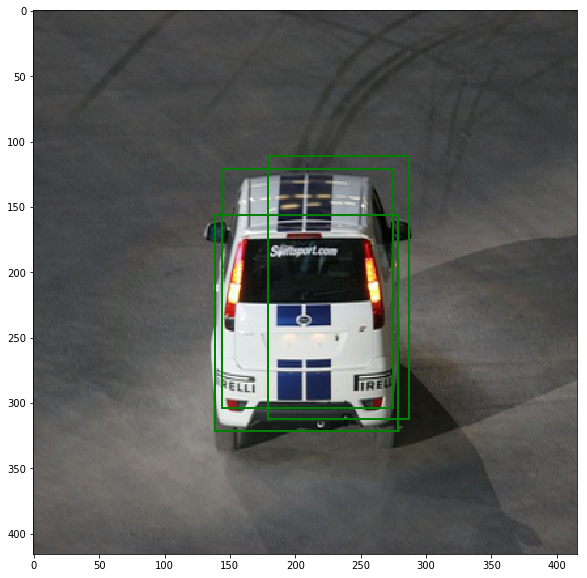

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
for box in boxes:
    xmin  = int((box[0] - box[2]/2) * img.shape[1])
    ymin  = int((box[1] - box[3]/2) * img.shape[1])
    w = box[2] * img.shape[1]
    h = box[3] * img.shape[1]
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), w, h, fill=False, color='g', linewidth=2))
plt.show()

In [31]:
boxes[1][2] * 416

130.9624047888565

In [18]:
import tensorflow as tf

In [97]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]

    logits = tf.nn.sigmoid(y_pred_obj)
    obj_loss = tf.losses.sigmoid_cross_entropy(y_train_obj, logits)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    
    
    bbox_mse = tf.losses.mean_squared_error(bbox_true, bbox_pred)
    final_loss = obj_loss + bbox_mse
    
    return final_loss

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    logits = K.sigmoid(y_pred_obj)
    obj_loss = K.binary_crossentropy(y_train_obj, logits)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [11]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]

    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    final_loss = obj_loss + bbox_mse
    
    return final_loss, obj_loss, bbox_mse

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [17]:
def get_IOU(y_true, y_pred):
    
    copy_y_pred = tf.cast(y_pred, tf.float32)
    copy_y_true = tf.cast(y_true, tf.float32)
    
    centers_true = copy_y_true[:,:,:, 1:3] 
    whs_true = copy_y_true[:,:,:, 3: ] 
    centers_pred = copy_y_pred[:,:,:, 1:3]
    whs_pred = copy_y_pred[:,:,:, 3: ]

    
    xmin_gt = tf.expand_dims(centers_true[:,:,:, 0] - 0.5 * whs_true[:,:,:, 0], -1)
    ymin_gt = tf.expand_dims(centers_true[:,:,:, 1] - 0.5 * whs_true[:,:,:, 1], -1)
    xmax_gt = tf.expand_dims(whs_true[:,:,:, 0], -1) + xmin_gt
    ymax_gt = tf.expand_dims(whs_true[:,:,:, 1], -1) + ymin_gt
     

    xmin_pred = tf.expand_dims(centers_pred[:,:,:, 0] - 0.5 * whs_pred[:,:,:, 0], -1)
    ymin_pred = tf.expand_dims(centers_pred[:,:,:, 1] - 0.5 * whs_pred[:,:,:, 1], -1)
    xmax_pred = tf.expand_dims(whs_pred[:,:,:, 0], -1) + xmin_pred
    ymax_pred = tf.expand_dims(whs_pred[:,:,:, 1], -1) + ymin_pred


    max_cords_x = tf.maximum(xmin_gt, xmin_pred)
    max_cords_y = tf.maximum(ymin_gt, ymin_pred)
    min_cords_x = tf.minimum(xmax_gt, xmax_pred)
    min_cords_y = tf.minimum(ymax_gt, ymax_pred)

    intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))


    gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
    pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

    union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

    ious = tf.divide(intersect_area, union_area)

    #mean_iou = tf.reduce_mean(iou)

    return ious

In [18]:
def mean_IOU(y_true, y_pred):
    
    copy_y_pred = tf.cast(y_pred, tf.float32)
    copy_y_true = tf.cast(y_true, tf.float32)
    
    centers_true = copy_y_true[:,:,:, 1:3] 
    whs_true = copy_y_true[:,:,:, 3: ] 
    centers_pred = copy_y_pred[:,:,:, 1:3]
    whs_pred = copy_y_pred[:,:,:, 3: ]

    
    xmin_gt = tf.expand_dims(centers_true[:,:,:, 0] - 0.5 * whs_true[:,:,:, 0], -1)
    ymin_gt = tf.expand_dims(centers_true[:,:,:, 1] - 0.5 * whs_true[:,:,:, 1], -1)
    xmax_gt = tf.expand_dims(whs_true[:,:,:, 0], -1) + xmin_gt
    ymax_gt = tf.expand_dims(whs_true[:,:,:, 1], -1) + ymin_gt
     

    xmin_pred = tf.expand_dims(centers_pred[:,:,:, 0] - 0.5 * whs_pred[:,:,:, 0], -1)
    ymin_pred = tf.expand_dims(centers_pred[:,:,:, 1] - 0.5 * whs_pred[:,:,:, 1], -1)
    xmax_pred = tf.expand_dims(whs_pred[:,:,:, 0], -1) + xmin_pred
    ymax_pred = tf.expand_dims(whs_pred[:,:,:, 1], -1) + ymin_pred


    max_cords_x = tf.maximum(xmin_gt, xmin_pred)
    max_cords_y = tf.maximum(ymin_gt, ymin_pred)
    min_cords_x = tf.minimum(xmax_gt, xmax_pred)
    min_cords_y = tf.minimum(ymax_gt, ymax_pred)

    intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))


    gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
    pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

    union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

    ious = tf.divide(intersect_area, union_area)

    mean_iou = tf.reduce_mean(ious)

    return mean_iou

In [ ]:
def obj_accuracy(y_train, y_pred):
    
    obj_cells = tf.expand_dims(y_train[...,0], -1)
    noobj_cells = tf.expand_dims(1 - y_train[...,0], -1)
    
    obj_cells_pred = tf.expand_dims(y_pred[...,0], -1)
    noobj_cells_pred = tf.expand_dims(1 - y_pred[..., 0], -1)
    
    num_objects = tf.reduce_sum(tf.to_float(obj_cells > 0.0))
    num_no_objects = tf.reduce_sum(tf.to_float(noobj_cells > 0.0))
    
    obj_loss = 
    
    

In [158]:
K.eval(get_IOU(np.expand_dims(y_train[0], 0), preds))

array([[[[ -8.03285658e-01],
         [ -9.11334276e-01],
         [ -9.83248532e-01],
         [ -9.92743671e-01],
         [ -8.17814291e-01]],

        [[ -1.31903553e+00],
         [ -8.36130977e-01],
         [ -1.02104449e+00],
         [ -1.00714982e+00],
         [ -1.01430500e+00]],

        [[  2.84782033e-02],
         [ -1.07359111e+00],
         [ -1.02764443e-06],
         [ -1.00174570e+00],
         [ -1.05145848e+00]],

        [[ -1.00304580e+00],
         [ -1.03784418e+00],
         [ -1.03330874e+00],
         [ -1.01599312e+00],
         [ -1.00306869e+00]],

        [[ -9.88228440e-01],
         [ -9.95496273e-01],
         [ -9.98818219e-01],
         [ -1.01992941e+00],
         [ -1.03590846e+00]]]], dtype=float32)

In [19]:
def final_loss(real, preds):
    
    y_train = tf.cast(real, tf.float32)
    y_preds = tf.cast(preds, tf.float32)
    
    gt_boxes = y_train[...,1:]

    gt_conf = y_train[...,0]

    pred_boxes = y_preds[...,1:]

    pred_conf = tf.sigmoid(y_preds[...,0])
    
    obj_cells = tf.expand_dims(y_train[...,0], -1)
    noobj_cells = tf.expand_dims(1 - y_train[...,0], -1)
    
    num_objects = tf.reduce_sum(tf.to_float(obj_cells > 0.0))
    num_no_objects = tf.reduce_sum(tf.to_float(noobj_cells > 0.0))
    
    
    gt_w = gt_boxes[..., 2]
    gt_h = gt_boxes[..., 3]
    
    pred_w = pred_boxes[..., 2]
    pred_h = pred_boxes[..., 3]
    
    gt_centroid_x = gt_boxes[..., 0]
    gt_centroid_y = gt_boxes[..., 1]
    
    
    pred_centroid_x = pred_boxes[..., 0]
    pred_centroid_y = pred_boxes[..., 1]

        
    cent_loss = tf.square(gt_centroid_x - pred_centroid_x) + tf.square(gt_centroid_y - pred_centroid_y)
    
    centroid_loss = obj_cells * tf.expand_dims(cent_loss, 1)
    
    #wh_loss = tf.square(tf.sqrt(gt_w) - tf.sqrt(pred_w)) + tf.square(tf.sqrt(gt_h) - tf.sqrt(pred_h))
    
    wh_loss = tf.square(gt_w - pred_w) + tf.square(gt_h - pred_h)
    
    width_height_loss = obj_cells * tf.expand_dims(wh_loss, 1)
    
    
    coord_loss = tf.reduce_sum(centroid_loss + width_height_loss)
    
    mean_coord_loss = coord_loss / (num_objects + 1e-5)
    
    
    obj_pred_confs = tf.expand_dims(pred_conf, -1) * get_IOU(y_train, y_preds) 
    
    obj_conf_loss = tf.reduce_sum(obj_cells * (tf.expand_dims(gt_conf, -1) - obj_pred_confs))
    
    noobj_conf_loss = tf.reduce_sum(noobj_cells * (tf.expand_dims(gt_conf, -1) - obj_pred_confs))
    
    mean_obj_conf_loss = obj_conf_loss / (num_objects + 1e-5)
    
    mean_noobj_conf_loss = noobj_conf_loss / (num_no_objects + 1e-5)

    
    final_loss = 5 * mean_coord_loss + 5 * mean_obj_conf_loss + 0.5 * mean_noobj_conf_loss
        
    return final_loss

In [ ]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [24]:

def exp_loss(y_true, preds):
    
    pred = tf.cast(preds, tf.float32)
    y_true = tf.cast(y_true, tf.float32)


    mask_shape = tf.shape(preds)[:4]

    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(5), [5]), (1, 5, 5, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid =tf.concat([cell_x,cell_y], -1)

    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)


    pred_box_xy = tf.sigmoid(preds[..., 1:3]) + cell_grid

    ### adjust w and h
    pred_box_wh = tf.exp(preds[..., 3:])

    ### adjust confidence
    pred_box_conf = tf.sigmoid(preds[..., 0])


    true_box_xy = y_true[..., 1:3] # relative position to the containing cell

        ### adjust w and h
    true_box_wh = y_true[..., 3:] # number of cells accross, horizontally and vertically

        ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       


    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 0]





    coord_mask = tf.expand_dims(y_true[..., 0], axis=-1) * 1

    mask = tf.equal(y_true[..., 0], 1)
    true_boxes = tf.boolean_mask(y_true, mask)

    true_xy = true_boxes[..., 1:3]

    true_wh = true_boxes[..., 3:]

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  tf.cast(true_mins, tf.float32))


    intersect_maxes = tf.minimum(pred_maxes, tf.cast(true_maxes, tf.float32))
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + tf.cast(true_areas, tf.float32) - tf.cast(intersect_areas, tf.float32)
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)


    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 0]) * 1
    conf_mask = conf_mask + y_true[..., 0] * 5

    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))


    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.

    loss = loss_xy + loss_wh + loss_conf

    nb_true_box = tf.reduce_sum(y_true[..., 0])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
    
    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    
    ### priting total loss

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    return loss

In [98]:
Det_model.compile(optimizer='rmsprop', loss=custom_loss, metrics=[obj_loss, bbox_loss, IOU])

In [21]:
optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.0)

In [21]:
filepath="multibox-{epoch:02d}-{val_mean_IOU:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_IOU', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
Det_model.compile(optimizer=optim, loss=exp_loss)

In [26]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=3 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/3
1668/1668 [==============================] - 1125s 675ms/step - loss: 5.1510 - val_loss: 5.0621
Epoch 2/3
1668/1668 [==============================] - 575s 345ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 3/3
1668/1668 [==============================] - 576s 345ms/step - loss: 5.1194 - val_loss: 5.0621


In [27]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=5 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/5
1668/1668 [==============================] - 571s 342ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 2/5
1668/1668 [==============================] - 568s 341ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 3/5
1668/1668 [==============================] - 568s 341ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 4/5
1668/1668 [==============================] - 568s 340ms/step - loss: 5.1194 - val_loss: 5.0621
Epoch 5/5
1668/1668 [==============================] - 568s 340ms/step - loss: 5.1194 - val_loss: 5.0621


In [31]:
Det_model.fit_generator(training_generator, 26688 // 16, epochs=5 ,validation_data=validation_generator, validation_steps=400//16)

Epoch 1/5
1668/1668 [==============================] - 1553s 931ms/step - loss: 121955.8972 - mean_IOU: 0.5599 - val_loss: 127673.4006 - val_mean_IOU: 0.5600
Epoch 2/5
1668/1668 [==============================] - 904s 542ms/step - loss: 111726.2227 - mean_IOU: 0.5949 - val_loss: 128923.9286 - val_mean_IOU: 0.6231
Epoch 3/5
1668/1668 [==============================] - 1149s 689ms/step - loss: 99017.4025 - mean_IOU: 0.6439 - val_loss: 133172.1641 - val_mean_IOU: 0.6768
Epoch 4/5
1668/1668 [==============================] - 551s 331ms/step - loss: 82473.7782 - mean_IOU: 0.6952 - val_loss: 139867.4750 - val_mean_IOU: 0.7152
Epoch 5/5
1668/1668 [==============================] - 533s 320ms/step - loss: 64571.1897 - mean_IOU: 0.7420 - val_loss: 146847.5013 - val_mean_IOU: 0.7451


In [26]:
load_model?

In [30]:
Det_model = load_model('./multibox-06-0.76.hdf5',compile=False)

In [31]:
Det_model.compile(optimizer=optim, loss=final_loss, metrics=[mean_IOU])

In [48]:
preds = Det_model.predict(np.expand_dims(x_train[1], 0))

In [136]:
preds = Det_model.predict(x_train)

In [20]:
BATCH_SIZE=1

In [73]:
mask_shape = tf.shape(preds)[:4]
print(mask_shape.shape)   
cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(5), [5]), (1, 5, 5, 1, 1)))
cell_y = tf.transpose(cell_x, (0,2,1,3,4))
print(cell_x.shape)
print(cell_y.shape)
cell_grid =tf.concat([cell_x,cell_y], -1)
print(cell_grid.shape)

(4,)
(1, 5, 5, 1, 1)
(1, 5, 5, 1, 1)
(1, 5, 5, 1, 2)


In [75]:
coord_mask = tf.zeros(mask_shape)
conf_mask  = tf.zeros(mask_shape)
print(coord_mask.shape, conf_mask.shape)

(1, 5, 5, 1) (1, 5, 5, 1)


In [76]:
pred_box_xy = tf.sigmoid(preds[..., 1:3]) + cell_grid

### adjust w and h
pred_box_wh = tf.exp(preds[..., 3:])

### adjust confidence
pred_box_conf = tf.sigmoid(preds[..., 0])

In [78]:
pred_box_xy.shape, pred_box_wh.shape, pred_box_conf.shape

(TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(1), Dimension(5), Dimension(5), Dimension(1)]))

In [81]:
y_true = y_train[1]

In [82]:
true_box_xy = y_true[..., 1:3] # relative position to the containing cell

    ### adjust w and h
true_box_wh = y_true[..., 3:] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
true_wh_half = true_box_wh / 2.
true_mins    = true_box_xy - true_wh_half
true_maxes   = true_box_xy + true_wh_half
    
pred_wh_half = pred_box_wh / 2.
pred_mins    = pred_box_xy - pred_wh_half
pred_maxes   = pred_box_xy + pred_wh_half       

In [83]:
intersect_mins  = tf.maximum(pred_mins,  true_mins)
intersect_maxes = tf.minimum(pred_maxes, true_maxes)
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

union_areas = pred_areas + true_areas - intersect_areas
iou_scores  = tf.truediv(intersect_areas, union_areas)

true_box_conf = iou_scores * y_true[..., 0]

In [92]:
mask = y_true[..., 0] == 1 
true_boxes = tf.boolean_mask(y_true, mask)

In [98]:
true_xy = true_boxes[..., 1:3]

true_wh = true_boxes[..., 3:]
    
true_wh_half = true_wh / 2.
true_mins    = true_xy - true_wh_half
true_maxes   = true_xy + true_wh_half

pred_xy = tf.expand_dims(pred_box_xy, 4)
pred_wh = tf.expand_dims(pred_box_wh, 4)

pred_wh_half = pred_wh / 2.
pred_mins    = pred_xy - pred_wh_half
pred_maxes   = pred_xy + pred_wh_half    

intersect_mins  = tf.maximum(pred_mins,  tf.cast(true_mins, tf.float32))


In [110]:
intersect_maxes = tf.minimum(pred_maxes, tf.cast(true_maxes, tf.float32))
intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

true_areas = true_wh[..., 0] * true_wh[..., 1]
pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

union_areas = pred_areas + tf.cast(true_areas, tf.float32) - tf.cast(intersect_areas, tf.float32)
iou_scores  = tf.truediv(intersect_areas, union_areas)

best_ious = tf.reduce_max(iou_scores, axis=4)

In [113]:
conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 0]) * 1

In [118]:
conf_mask = conf_mask + y_true[..., 0] * 5

In [120]:
nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))

In [123]:
loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.

In [128]:
K.eval(loss_conf)

1.135148

In [ ]:
loss = loss_xy + loss_wh + loss_conf

In [130]:
nb_true_box = tf.reduce_sum(y_true[..., 0])
nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

In [145]:
K.eval(exp_loss(y_train, preds))

57.774445

#### excellent indexing my way to get to know bboxes

In [163]:
y_train[3, (y_train[3, :, :,0] == 1)]

array([[  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [152]:
y_train[3, (y_train[3, :, :, 0] == 0)]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [157]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_objects_mask.shape

(4, 5, 5)

In [162]:
y_train[true_objects_mask]

array([[  1,  86, 132, 137, 224],
       [  1,  41,  25,  86, 224],
       [  1,   0, 165,  12, 197],
       [  1, 203, 165, 224, 188],
       [  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [ ]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_object_inputs = y_train[true_objects_mask]
no_objects_mask = (y_train[:, :, :, 0] == 0)
no_objects_inputs = y_train[no_objects_mask]
object_presence_input = true_object_inputs[]

#### end of excellent bboxes ----------------------------------

In [139]:
y_train[3, :, :,]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,   4,  65, 223, 160],
        [  1, 145, 115, 184, 136],
        [  1, 188, 122, 215, 138]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [117]:
y_train[:, :, :, 0], y_train[:, :, :, 1:]

ValueError: operands could not be broadcast together with shapes (4,5,5) (4,5,5,4) 

In [100]:
y_train[:, :, :, 0] , preds[:, :, :, 0]

(array([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]]),
 array([[[ 0.42867598,  0.35086715,  0.36378124,  0.44020969,  0.27385515],
         [ 0.36352858,  0.30997095,  0.27112961,  0.29356119,  0.2511214 ],
         [ 0.39785787,  0.41767052,  0.42296398,  0.45114487,  0.49524561],
         [ 0.49022552,  0.36892691,  0.5450815 ,  0.47621793,  0.47110999],
         [ 0.41960067,  0.21940452,  0.42835286,  0.48870707,  0.33372861]],
 
        [[ 0.32878578,  0.20636937,  0.40615219,  0.37054703,  0.36474374],
         

In [88]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.90204424

In [101]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.99500221

In [106]:
K.eval(tf.losses.mean_squared_error(y_train[:, :, :, 1:], preds[:, :, :, 1:]))

1637.3862

In [ ]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

In [90]:
K.eval(obj_loss(tf.cast(y_train, tf.float32), preds))

array([[[ 0.53859133,  0.51714879,  0.54043227,  0.5464685 ,  0.64806491],
        [ 0.58427513,  0.56883425,  0.53052199,  0.56055307,  0.56320405],
        [ 0.57744271,  0.55141258,  0.51703477,  0.48698473,  0.55709988],
        [ 0.51439691,  0.50974256,  0.52287447,  0.56566709,  0.62095225],
        [ 0.49376696,  0.56390315,  0.85689807,  0.52101743,  0.5718323 ]],

       [[ 0.50787371,  0.48642069,  0.47709545,  0.60087919,  0.59825581],
        [ 0.41038316,  0.42545384,  0.49284297,  0.53017271,  0.58465898],
        [ 0.47485501,  0.92320013,  0.55151623,  0.58343863,  0.60649961],
        [ 0.60665196,  0.58281565,  0.57652968,  0.59013504,  0.62048614],
        [ 0.66512483,  0.66780126,  0.68053353,  0.6591273 ,  0.65778345]],

       [[ 0.55384219,  0.59769475,  0.62833428,  0.66913176,  0.70161736],
        [ 0.56257105,  0.58055651,  0.62696242,  0.62081492,  0.66759998],
        [ 0.54214835,  0.57442898,  0.54021269,  0.55123687,  0.61313766],
        [ 0.51506382,

In [86]:
K.eval(tf.round(tf.nn.sigmoid(preds[:,:,:,0]))) == np.round(sig_out, 0)

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]], dtype=bool)

In [85]:
np.round(sig_out, 0)

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]], dtype=float32)

In [49]:
Det_model.compile(optimizer='rmsprop', loss=obj_loss)

In [25]:
len(final_parition['train']), len(final_parition['val'])

(26688, 400)

In [50]:
Det_model.fit_generator(training_generator, 26688 // 4, epochs=3 ,validation_data=validation_generator, validation_steps=400//4)

Epoch 1/3
  37/6672 [..............................] - ETA: 42:00 - loss: -276254.4040

KeyboardInterrupt: 

In [21]:
y_train[:, ].shape

(16, 5, 5)

In [33]:
test = y_train[1]

In [30]:
test[:, :, 1].shape

(5, 5)

In [49]:
test

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [55]:
test[:, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

In [42]:
test[]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [58]:
y_pred = np.zeros((16, 5, 5))

In [59]:
y_pred

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 

In [22]:
y_train[:, :, :, 0]

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0,

In [25]:
y_train[:, :, :, 1:].shape

(16, 5, 5, 4)

In [57]:
np.argmax(y_train[0, :, :, 0], axis=())

array([0, 0, 2, 0, 0], dtype=int64)

In [60]:
y_train[1, :, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

#### code snippet for the IOU

In [68]:
xmin_gt, xmin_pred =  y_train[:, :, :, 0], y_pred[:, :, :, 0]
ymin_gt, ymin_pred =  y_train[:, :, :, 1], y_pred[:, :, :, 1]
xmax_gt, xmax_pred =  y_train[:, :, :, 2], y_pred[:, :, :, 2]
ymax_gt, ymax_pred =  y_train[:, :, :, 3], y_pred[:, :, :, 3]


max_cords_x = tf.maximum(xmin_gt, xmin_pred)
max_cords_y = tf.maximum(ymin_gt, ymin_pred)

min_cords_x = tf.minimum(xmax_gt, xmax_pred)
min_cords_y = tf.minimum(ymax_gt, ymax_pred)

intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))

gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

iou = tf.divide(intersect_area / union_area)

In [38]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [71]:
def sigmoid_cross_entropy(true, pred):
    return - np.sum(np.multiply(true, np.log(pred)))
    